In [3]:
!pip install prophet



Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.3990e-04 - val_loss: 0.0032
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0123e-05 - val_loss: 0.0038
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0002e-05 - val_loss: 0.0032
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.7693e-06 - val_loss: 0.0022
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.1700e-06 - val_loss: 0.0026
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.1702e-06 - val_loss: 0.0025
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.3321e-06 - val_loss: 0.0026
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.2548e-06 - val_loss: 0.0029
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.8595e-06 - val_loss: 0.0023
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.1743e-06 - val_loss: 0.0019
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.9351e-06 - val_loss: 0.0020
Epoch 12/50
73/73 ━━━━━━━━━━━━

14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:45 - cmdstanpy - INFO - Chain [1] done processing


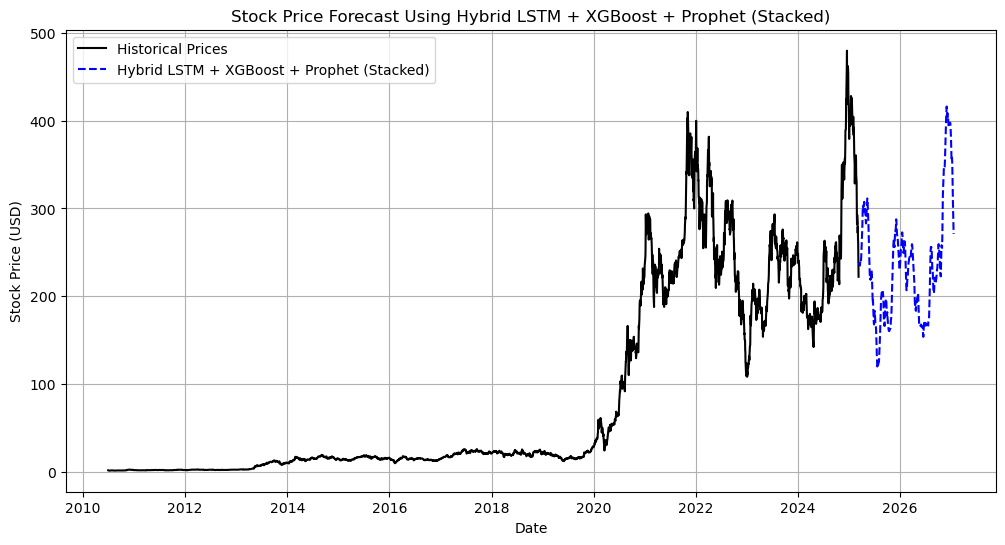

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from prophet import Prophet
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load dataset
df = pd.read_csv("/Users/disastershubz/Downloads/MacroTrends_Data_Download_TSLA.csv", skiprows=14)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['close', 'volume']])
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=['close', 'volume'])

# Train-Test Split
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:]

# 📌 LSTM Model
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data.iloc[i-time_steps:i].values)
        y.append(data['close'].iloc[i])
    return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Align test set
test = test.iloc[time_steps:]

lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

lstm_pred = lstm_model.predict(X_test)

# 📌 XGBoost Model
train_xgb = train[['close', 'volume']]
test_xgb = test[['close', 'volume']]
xgb_model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, subsample=0.9)
xgb_model.fit(train_xgb, train['close'])
xgb_pred = xgb_model.predict(test_xgb)

# 📌 Prophet Model for Long-Term Trends
prophet_df = df.reset_index()[['date', 'close']]
prophet_df.columns = ['ds', 'y']

prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_df)
future_dates = prophet.make_future_dataframe(periods=len(test), freq='D')
prophet_pred = prophet.predict(future_dates)['yhat'].iloc[-len(test):].values

# 📌 Align Predictions (Trim to Minimum Length)
min_len = min(len(lstm_pred), len(xgb_pred), len(prophet_pred))
lstm_pred, xgb_pred, prophet_pred = lstm_pred[:min_len], xgb_pred[:min_len], prophet_pred[:min_len]

# 📌 Rescale Predictions Back to Original Prices
dummy_array = np.zeros((min_len, df_scaled.shape[1]))
dummy_array[:, 0] = lstm_pred.flatten()
lstm_fixed = scaler.inverse_transform(dummy_array)[:, 0]

dummy_array[:, 0] = xgb_pred.flatten()
xgb_fixed = scaler.inverse_transform(dummy_array)[:, 0]

dummy_array[:, 0] = prophet_pred.flatten()
prophet_fixed = scaler.inverse_transform(dummy_array)[:, 0]

# 📌 Train Ridge Regression Meta-Model (Stacking)
meta_X = np.column_stack((lstm_fixed, xgb_fixed, prophet_fixed))
meta_y = df['close'].iloc[-min_len:].values

meta_model = Ridge(alpha=0.5)
meta_model.fit(meta_X, meta_y)

final_pred = meta_model.predict(meta_X)

# 📌 Apply Rolling Average for Additional Smoothing
final_pred_smooth = pd.Series(final_pred).rolling(window=5).mean()

# 📌 Generate Future Dates
future_dates = pd.date_range(start=test.index[-1], periods=len(final_pred_smooth) + 1, freq='D')[1:]

# 📌 Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="Historical Prices", color="black")
plt.plot(future_dates[:len(final_pred_smooth)], final_pred_smooth, label="Hybrid LSTM + XGBoost + Prophet (Stacked)", linestyle="dashed", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Stock Price Forecast Using Hybrid LSTM + XGBoost + Prophet (Stacked)")
plt.legend()
plt.grid(True)
plt.show()
